<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part6/P6_Ch02_CH02_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model training - CNN approach


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from glob import glob
from tqdm import tqdm

In [4]:
LABEL_INT_DICT = np.unique(pd.read_csv('/content/drive/MyDrive/딥러닝 정주행/P6_Ch02.동영상처리실습/ucf11_train_vid.csv')['label'])
LABEL_STR_DICT = { k:v for v, k in enumerate(LABEL_INT_DICT)}
pprint(LABEL_INT_DICT)
pprint(LABEL_STR_DICT)


array(['biking', 'diving', 'golf', 'juggle', 'jumping', 'riding',
       'shooting', 'spiking', 'swing', 'tennis', 'walk'], dtype=object)
{'biking': 0,
 'diving': 1,
 'golf': 2,
 'juggle': 3,
 'jumping': 4,
 'riding': 5,
 'shooting': 6,
 'spiking': 7,
 'swing': 8,
 'tennis': 9,
 'walk': 10}


In [5]:
import albumentations as A
import math
import tensorflow as tf
from tensorflow import keras


class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, image_size, mode ='train', shuffle =True):
        assert mode in ['train', 'valid']

        self.mode = mode
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.image_size = image_size

        if self.mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p = 0.5),
                A.ShiftScaleRotate(
                    p = 0.5,
                    shift_limit = 0.05,
                    scale_limit = 0.05,
                    rotate_limit = 15
                )
            ])
        self.img_paths = glob(
            f'/content/drive/MyDrive/딥러닝 정주행/P6_Ch02.동영상처리실습/UCF11_updated_png/{mode}/*.png'
        )
    def __len__(self):
        return math.ceil(len(self.img_paths)/ self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.img_paths[strt:fin]

        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)

    def get_data(self, data):
        batch_x = []
        batch_y = []

        for img_path in data:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.image_size, self.image_size))

            if self.mode == 'train':
                augmented = self.transform(image = img)
                img = augmented['image']

            img = img.astype('float32')
            img = img /255.

            label = img_path.split('/')[-1].split('_')[0]
            label = LABEL_STR_DICT[label]

            batch_x.append(img)
            batch_y.append(label)

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle :
            random.shuffle(self.img_paths)

train_generator = DataGenerator(
    mode = 'train',
    batch_size = 128,
    image_size = 256,
    shuffle = True
)
valid_generator = DataGenerator(
    mode = 'valid',
    batch_size = 128,
    image_size = 256,
    shuffle = True
)

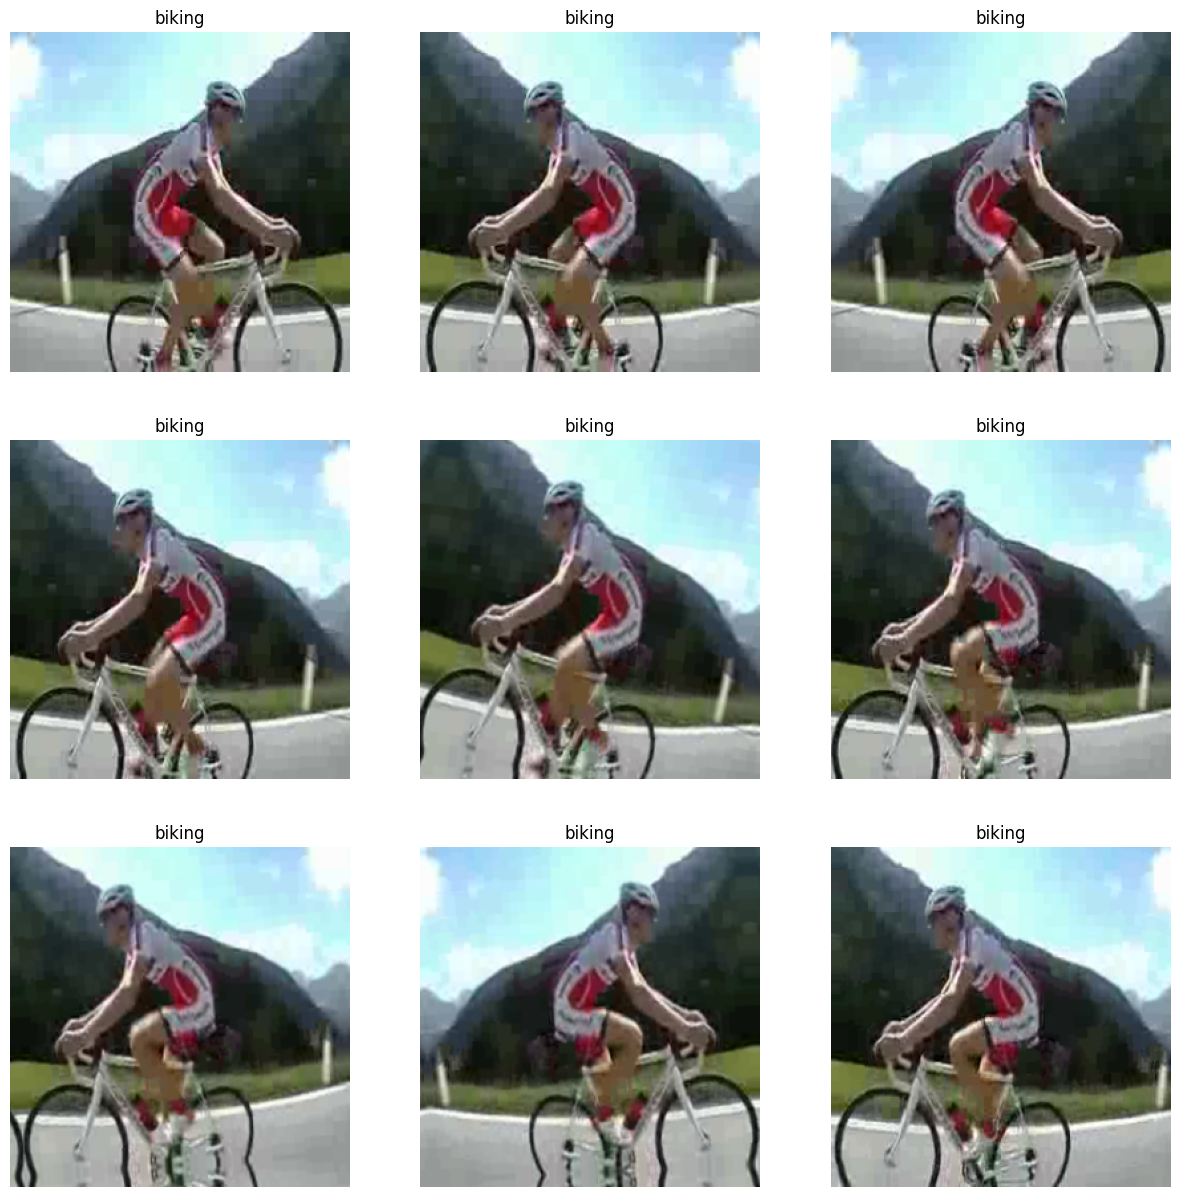

In [6]:
for batch in train_generator:
    X, y = batch
    plt.figure(figsize = (15,15))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(X[i])
        plt.title(LABEL_INT_DICT[y[i]])
        plt.axis('off')

    break

In [7]:
import os
import tensorflow_hub as hub

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2", trainable=True),
    keras.layers.Dense(len(LABEL_INT_DICT), activation = 'softmax')
]
)
model.build([None, 256, 256, 3])
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(
    optimizer = adam,
    loss = 'sparse_categorical_crossentropy',
    metrics = 'accuracy'
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              5919312   
                                                                 
 dense (Dense)               (None, 11)                14091     
                                                                 
Total params: 5933403 (22.63 MB)
Trainable params: 5872795 (22.40 MB)
Non-trainable params: 60608 (236.75 KB)
_________________________________________________________________


In [8]:
# os.mkdir('/content/drive/MyDrive/딥러닝 정주행/P6_Ch02.동영상처리실습/ucf11_weights')
filepath = '/content/drive/MyDrive/딥러닝 정주행/P6_Ch02.동영상처리실습/ucf11_weights/{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath, monitor ='val_loss', mode ='min', verbose =1,
    save_best_only = True, save_weights_only = False
)

history = model.fit(
    train_generator,
    validation_data= valid_generator,
    epochs = 10,
    callbacks = [
        model_checkpoint
    ]
)

Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 2.4734 - accuracy: 0.0823
Epoch 1: val_loss improved from inf to 2.32495, saving model to /content/drive/MyDrive/딥러닝 정주행/P6_Ch02.동영상처리실습/ucf11_weights/01-0.19.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 315s 15s/step - loss: 2.4734 - accuracy: 0.0823 - val_loss: 2.3249 - val_accuracy: 0.1891
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 2.1269 - accuracy: 0.3573
Epoch 2: val_loss improved from 2.32495 to 2.13070, saving model to /content/drive/MyDrive/딥러닝 정주행/P6_Ch02.동영상처리실습/ucf11_weights/02-0.33.hdf5
18/18 [==============================] - 20s 1s/step - loss: 2.1269 - accuracy: 0.3573 - val_loss: 2.1307 - val_accuracy: 0.3327
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 1.6306 - accuracy: 0.7436
Epoch 3: val_loss improved from 2.13070 to 1.75813, saving model to /content/drive/MyDrive/딥러닝 정주행/P6_Ch02.동영상처리실습/ucf11_weights/03-0.55.hdf5
18/18 [==============================] - 20s 1s/step - loss: 1.6306 - accuracy: 0.7436 - val_loss: 1.7581 - val_accuracy: 0.5455
Epoch 4/10
18/18 [==============================] - ETA: 0s - loss: 1.0697 - accuracy: 0.9027
E

<function matplotlib.pyplot.show(close=None, block=None)>

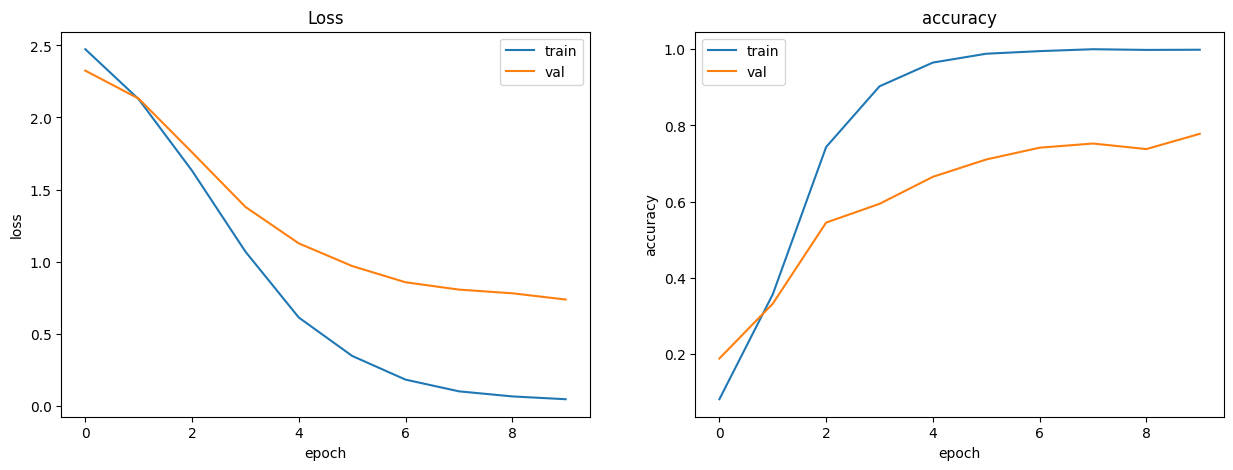

In [11]:
import matplotlib.pyplot as plt
# history = history.history

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(history['loss'], label ='train')
plt.plot(history['val_loss'], label = 'val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label ='train')
plt.plot(history['val_accuracy'], label = 'val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')
plt.show


In [14]:
csv_path = '/content/drive/MyDrive/딥러닝 정주행/P6_Ch02.동영상처리실습/ucf11_valid_vid.csv'
valid_df = pd.read_csv(csv_path)

correct = 0
for i, elem in tqdm(valid_df.iterrows(),
                    total = len(valid_df)):
    cap = cv2.VideoCapture(
        elem['file_path']
    )

    preds =[]
    while True :
        ret, frame = cap.read()

        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (256, 256))
        frame = frame.astype('float32')
        frame /= 255.

        pred = model.predict(frame[np.newaxis, ...])
        preds.append(pred)

    preds = np.array(preds).mean(axis =0) # 비디오 예측 = 모든프레임 예측의 평균
    label = LABEL_INT_DICT[np.argmax(preds)]

    if label == elem['label']:
        correct +=1

    cap.release()

print("Accuracy: ", correct /len(valid_df))

  0%|          | 0/55 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 1/55 [00:23<21:30, 23.89s/it]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 2/55 [00:45<19:59, 22.62s/it]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 3/55 [01:03<17:55, 20.68s/it]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 4/55 [01:37<21:59, 25.87s/it]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 5/55 [01:53<18:33, 22.27s/it]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 6/55 [02:07<15:41, 19.22s/it]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 7/55 [02:20<13:52, 17.35s/it]

1/1 [==============================] - 0s 45ms/step


 15%|█▍        | 8/55 [02:30<11:38, 14.86s/it]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 9/55 [02:38<09:51, 12.87s/it]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 10/55 [02:52<09:48, 13.07s/it]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 11/55 [03:20<12:57, 17.66s/it]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 12/55 [03:35<12:12, 17.03s/it]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 13/55 [03:52<11:47, 16.84s/it]

1/1 [==============================] - 0s 47ms/step


 25%|██▌       | 14/55 [04:08<11:21, 16.63s/it]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 15/55 [04:18<09:51, 14.80s/it]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 16/55 [04:38<10:36, 16.31s/it]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 17/55 [04:57<10:52, 17.16s/it]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 18/55 [05:12<10:02, 16.29s/it]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 19/55 [05:27<09:37, 16.05s/it]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 20/55 [05:37<08:12, 14.08s/it]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 21/55 [05:57<09:03, 15.99s/it]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 22/55 [06:18<09:36, 17.47s/it]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 23/55 [06:35<09:12, 17.27s/it]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 24/55 [06:55<09:20, 18.08s/it]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 25/55 [07:15<09:24, 18.82s/it]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 26/55 [07:27<08:04, 16.72s/it]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 27/55 [07:50<08:41, 18.63s/it]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 28/55 [08:00<07:12, 16.04s/it]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 29/55 [08:11<06:19, 14.61s/it]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 30/55 [08:26<06:04, 14.60s/it]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 31/55 [08:44<06:14, 15.62s/it]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 32/55 [09:01<06:10, 16.11s/it]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 33/55 [09:23<06:29, 17.68s/it]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 34/55 [09:43<06:27, 18.43s/it]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 35/55 [10:06<06:35, 19.78s/it]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 36/55 [10:15<05:14, 16.56s/it]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 37/55 [10:36<05:23, 17.99s/it]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 38/55 [10:42<04:04, 14.39s/it]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 39/55 [10:53<03:34, 13.43s/it]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 40/55 [11:08<03:27, 13.86s/it]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 41/55 [11:25<03:26, 14.77s/it]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 42/55 [11:38<03:03, 14.14s/it]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 43/55 [11:48<02:37, 13.10s/it]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 44/55 [11:56<02:07, 11.62s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 45/55 [12:12<02:07, 12.78s/it]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 46/55 [12:29<02:07, 14.12s/it]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 47/55 [12:46<02:00, 15.05s/it]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 48/55 [13:02<01:46, 15.27s/it]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 49/55 [13:24<01:43, 17.25s/it]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 50/55 [13:40<01:23, 16.77s/it]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 51/55 [13:52<01:01, 15.31s/it]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 52/55 [14:00<00:40, 13.38s/it]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 53/55 [14:15<00:27, 13.62s/it]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 54/55 [14:21<00:11, 11.50s/it]

1/1 [==============================] - 0s 38ms/step


100%|██████████| 55/55 [14:29<00:00, 15.80s/it]

Accuracy:  0.7636363636363637
